# Spectrum alignment

OpenMS provides several ways to find matching peaks between two spectra.
The most basic one SpectrumAlignment returns a list of matching peak
indices between a query and target spectrum. In this example, we take an
observed (measured) spectrum and align a theoretical spectrum to it.

First we load a (chemically modified) peptide:

In [ ]:
from urllib.request import urlretrieve
from pyopenms import *
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
urlretrieve (gh + "/src/data/YIC(Carbamidomethyl)DNQDTISSK.mzML", "observed.mzML")

exp = MSExperiment()
# Load mzML file and obtain spectrum for peptide YIC(Carbamidomethyl)DNQDTISSK
MzMLFile().load("observed.mzML", exp)

# Get first spectrum
spectra = exp.getSpectra()
observed_spectrum = spectra[0]

Now we generate the theoretical spectrum of that peptide:

In [ ]:
tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = AASequence.fromString("YIC(Carbamidomethyl)DNQDTISSK")
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)        

Now we can plot the observed and theoretical spectrum as a mirror plot:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

obs_mz, obs_int = observed_spectrum.get_peaks()

# The mass-to-charge of our observed spectrum ranges from 200 - 800 m/z
print(min(obs_mz)) # 212.012451171875
print(max(obs_mz)) # 795.2837524414062

# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

which produces

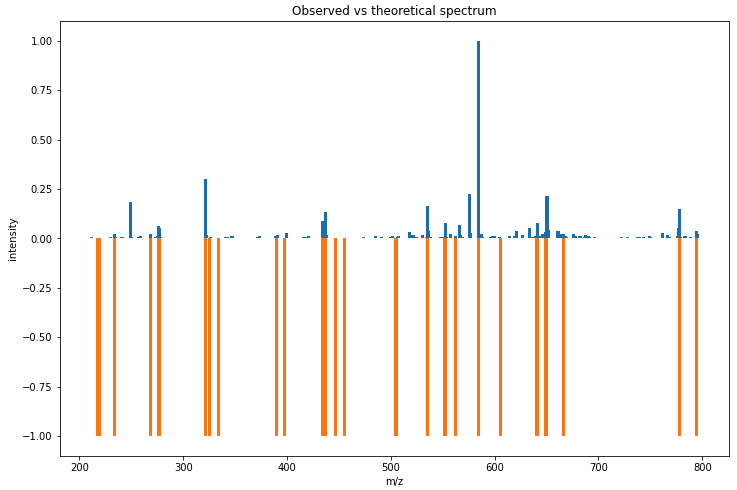

Now we want to find matching peaks between observed and theoretical
spectrum.

In [ ]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
# use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")  
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

The alignment contains a list of matched peak indices. We can simply
inspect matching peaks with:

In [ ]:
# Print matching ions and mz from theoretical spectrum
print("Number of matched peaks: " + str(len(alignment)))
print("ion\ttheo. m/z\tobserved m/z")

for theo_idx, obs_idx in alignment:
    ion_name = theo_spectrum.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spectrum.getIntegerDataArrays()[0][theo_idx]
    print(ion_name + "\t" + str(ion_charge) + "\t"
      + str(theo_spectrum[theo_idx].getMZ())
      + "\t" + str(observed_spectrum[obs_idx].getMZ()))

The mirror plot can also be used to visualize the aligned spectrum:

In [ ]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

which produces

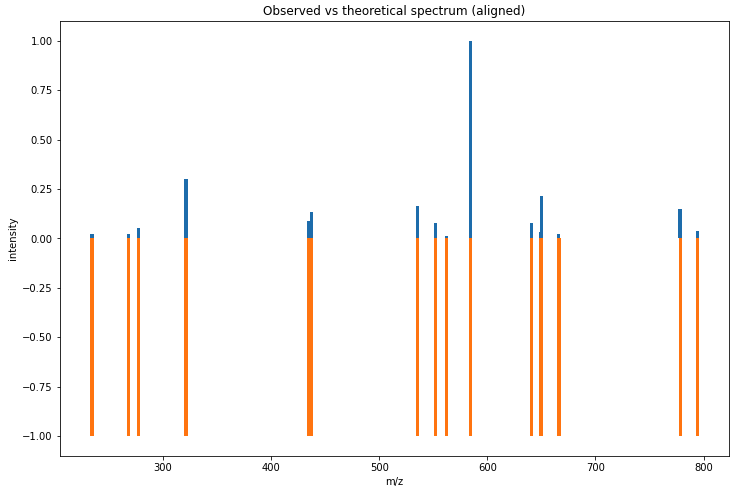